<a href="https://colab.research.google.com/github/adikeshn/Insulin-Dosage-Model/blob/main/Insulin-Dosage-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vowpalwabbit
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00


# Hyperparameter tuning

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datetime
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate
from gym import spaces
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
def pre_proccessing(name):

  df = pd.read_csv(f"{name}.csv")
  df["Timestamp (YYYY-MM-DDThh:mm:ss)"] = pd.to_datetime(df["Timestamp (YYYY-MM-DDThh:mm:ss)"])

  df = df[["Timestamp (YYYY-MM-DDThh:mm:ss)",
          "Glucose Value (mg/dL)",
          "Insulin Value (u)",
          "Event Subtype",
          "Carb Value (grams)"]]
  df = df.rename(columns={"Timestamp (YYYY-MM-DDThh:mm:ss)": "Time", "Glucose Value (mg/dL)" : "Glucose", "Insulin Value (u)": "Insulin", "Carb Value (grams)": "Carbs"})

  df = df.dropna(subset=["Time"])

  df["Event Subtype"] = df["Event Subtype"].fillna("none")
  df["Insulin"] = df["Insulin"].fillna(0)
  df["Carbs"] = df["Carbs"].fillna(0)
  df['Glucose'] = pd.to_numeric(df['Glucose'], errors='coerce')

  df["Glucose"] = df["Glucose"].ffill()
  df['Glucose'] = df['Glucose'] / 10

  df["Short-Acting"] = 0
  df["Long-Acting"] = 0
  df["TimeOfDay"] = df["Time"].dt.hour
  for index, row in df.iterrows():
    if row["Event Subtype"] == "Long-Acting":
      df.loc[index, "Long-Acting"] = row["Insulin"]
    elif row["Event Subtype"] == "Fast-Acting":
      df.loc[index, "Short-Acting"] = row["Insulin"]

  df['Unix'] = df['Time'].astype(np.int64) // 10**9
  df["Unix"] = df["Unix"] - df.iloc[0]["Unix"]
  df["Unix"] = df["Unix"]/60
  #create a row called time that is evening, morning, afternoon
  df = df.drop("Insulin", axis=1)
  df = df.drop("Event Subtype", axis=1)
  df_initial = df

  glucose_values = df_initial["Glucose"].values

  insulin_values = (df_initial["Short-Acting"]/10).values
  scaler = MinMaxScaler()
  glucose_values_normalized = scaler.fit_transform(glucose_values.reshape(-1, 1)).flatten()
  moving_average_3 = pd.Series(glucose_values_normalized).rolling(window=7).mean().values
  data = np.column_stack((glucose_values_normalized, df_initial["TimeOfDay"].values, moving_average_3))
  #remove entries in data where atleast one value is null
  data = data[~np.isnan(data).any(axis=1)]
  return data, insulin_values, scaler, glucose_values, df_initial



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
data, insulin_values, scaler, glucose_reg, df =pre_proccessing('ThirdPatient')
target_range_min = scaler.fit_transform([[10], [glucose_reg.max()], [glucose_reg.min()]])[0][0]
target_range_max = scaler.transform([[16], [glucose_reg.max()], [glucose_reg.min()]])[0][0]

<ipython-input-3-f2728d97f749>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Event Subtype"] = df["Event Subtype"].fillna("none")


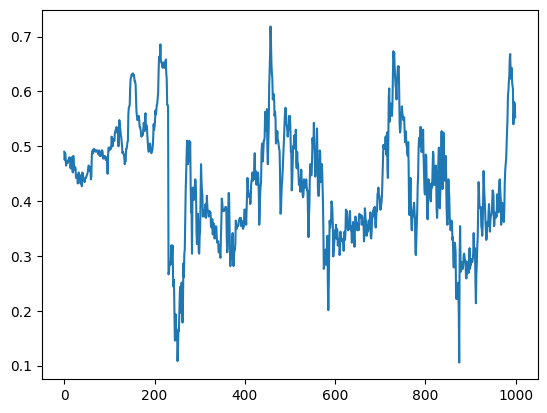

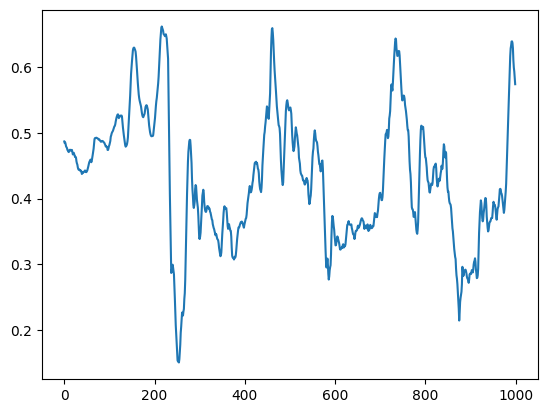

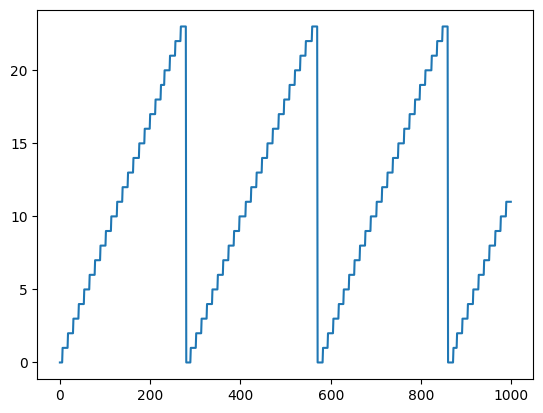

In [97]:
#plot the values in data
import matplotlib.pyplot as plt

#plot of unchanged data
plt.plot(data[:, 0][0:1000])
plt.show()

#plot of data with average window
plt.plot(data[:, 2][0:1000])
plt.show()

#plot of time data
plt.plot(data[:, 1][0:1000])
plt.show()

In [5]:
def create_time_series_windows(data, target, window_size):
    X, y, z = [], [], []
    for i in range(len(data) - window_size-window_size):
        if target[i + window_size] != 0:
            X.append(data[i:i + window_size])
            z.append(data[i + window_size+1: i+window_size+window_size+1])
            y.append([target[i + window_size]])
    return np.array(X), np.array(y), np.array(z)

X_train, y_train, affected = create_time_series_windows(data, insulin_values, 35)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.optimizers import Adam
import optuna

def objective(trial):
    # Define hyperparameters
    window_size = trial.suggest_int('window_size', 20, 50, step=5)
    units = trial.suggest_int('units', 32, 256, step=32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    epochs = trial.suggest_int('epochs', 10, 100, step=10)
    batch_size = trial.suggest_int('batch_size', 8, 64, step=8)
    validation_split = trial.suggest_float('validation_split', 0.1, 0.3, step=0.1)
    num_dense_layers = trial.suggest_int('num_dense_layers', 0, 3)  # New hyperparameter
    dense_units = [trial.suggest_int(f'dense_units_{i}', 32, 256, step=32) for i in range(num_dense_layers)]  # New hyperparameter

    X_train, y_train, affected = create_time_series_windows(data, insulin_values, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    input_layer = Input(shape=(window_size, X_train.shape[2]))
    layer = GRU(units)(input_layer)

    for units in dense_units:
        layer = Dense(units)(layer)

    insulin_output = Dense(1, name='insulin_output')(layer)

    model = Model(inputs=input_layer, outputs=[insulin_output])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError()
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    train_loss = model.evaluate(X_train, y_train, verbose=0)

    return train_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_hyperparameters = study.best_params
print("Best hyperparameters:", best_hyperparameters)


[I 2024-07-15 19:07:36,228] A new study created in memory with name: no-name-14afe70d-444f-4efa-9580-7bb0cdfbcff8
<ipython-input-13-74916923b988>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-07-15 19:08:18,291] Trial 0 finished with value: 0.03019009903073311 and parameters: {'window_size': 45, 'units': 256, 'learning_rate': 0.005426706735476946, 'epochs': 60, 'batch_size': 32, 'validation_split': 0.3, 'num_dense_layers': 2, 'dense_units_0': 224, 'dense_units_1': 192}. Best is trial 0 with value: 0.03019009903073311.
[I 2024-07-15 19:08:48,434] Trial 1 finished with value: 0.026579074561595917 and parameters: {'window_size': 50, 'units': 224, 'learning_rate': 0.0006312591062334525, 'epochs': 50, 'batch_size': 40, 'validation_split': 0.1, 'num_den

Best hyperparameters: {'window_size': 35, 'units': 64, 'learning_rate': 0.006171467689191571, 'epochs': 100, 'batch_size': 24, 'validation_split': 0.2, 'num_dense_layers': 3, 'dense_units_0': 32, 'dense_units_1': 128, 'dense_units_2': 32}


In [16]:
best_hyperparameters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'window_size': 35,
 'units': 64,
 'learning_rate': 0.006171467689191571,
 'epochs': 100,
 'batch_size': 24,
 'validation_split': 0.2,
 'num_dense_layers': 3,
 'dense_units_0': 32,
 'dense_units_1': 128,
 'dense_units_2': 32}

In [15]:
import optuna.visualization as vis


# Plot hyperparameter importances
fig = vis.plot_param_importances(study)
fig.show()

# Plot optimization history
fig = vis.plot_optimization_history(study)
fig.show()

# Plot slice plot
fig = vis.plot_slice(study)
fig.show()

# Plot parallel coordinate plot
fig = vis.plot_parallel_coordinate(study)
fig.show()

# Plot contour plot
fig = vis.plot_contour(study, params=['learning_rate', 'batch_size'])
fig.show()

In [26]:
window_size = best_hyperparameters['window_size']
X_train, y_train, affected = create_time_series_windows(data, insulin_values, window_size)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

input_layer = Input(shape=(window_size, X_train.shape[2]))
layer = GRU(best_hyperparameters['units'])(input_layer)

layer = Dense(best_hyperparameters['dense_units_0'])(layer)
layer = Dense(best_hyperparameters['dense_units_1'])(layer)
layer = Dense(best_hyperparameters['dense_units_2'])(layer)

insulin_output = Dense(1, name='insulin_output')(layer)

model = Model(inputs=input_layer, outputs=[insulin_output])

model.compile(
    optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
    loss=tf.keras.losses.MeanSquaredError()
)

model.fit(
    X_train, y_train,
    epochs=best_hyperparameters['epochs'],
    batch_size=best_hyperparameters['batch_size'],
    verbose=1
)

train_loss = model.evaluate(X_train, y_train)
print(f"Training Loss with Best Hyperparameters: {train_loss}")

Epoch 1/100
15/15 [==============================] - 4s 18ms/step - loss: 2.3056
Epoch 2/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1455
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0697
Epoch 4/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0478
Epoch 5/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0389
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0383
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0351
Epoch 8/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0357
Epoch 9/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0360
Epoch 10/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0325
Epoch 11/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0384
Epoch 12/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0328
Epoch 13/100
15/15 [=====

In [35]:
model.save("LSTM.keras")

In [6]:
model = tf.keras.models.load_model("LSTM.keras")
window_size = 35

# Step 2: Reinforcement Learning

In [87]:
from vowpalwabbit import pyvw

def format_example(action, context, reward):
    return f"{action}:{reward}: | {' '.join([f'{context[i]}' for i in range(context.shape[0])])}"

def format_example_pair(action, context, reward, LSTM):
    return f"{action}:{reward}: | {LSTM} {' '.join([f'{context[i]}' for i in range(context.shape[0])])}"



predictions = model.predict(X_train)
plain = X_train[:, :, 0]
avg = X_train[:, :, 2]
vw_plain = pyvw.vw("")
vw_avg = pyvw.vw("")
vw_pair = pyvw.vw("")
epochs = 1

for i in range(epochs):
  for i in range(X_train.shape[0]):

      context_1 = plain[i].reshape(window_size,)
      context_2 = avg[i].reshape(window_size,)

      LSTM_insulin = predictions[i][0]

      action = (y_train[i][0] - LSTM_insulin)

      affected_glucose = affected[i][:, 0]

      count = np.sum((affected_glucose >= target_range_min) & (affected_glucose <= target_range_max))
      reward = count / len(affected_glucose)

      vw_plain.learn(format_example((y_train[i][0]), context_1, reward))
      vw_avg.learn(format_example((y_train[i][0]), context_2, reward))
      vw_pair.learn(format_example_pair(action, context_1, reward, LSTM_insulin))



11/11 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-87-fdf38f99a57e>:15: DeprecationWarning: vw has been renamed to Workspace, the alias will be removed in the future
  vw_plain = pyvw.vw("")  # Example: using a contextual bandit algorithm


In [88]:
def format_context_train(context):
    return f"| {' '.join([f'{context[i]}' for i in range(context.shape[0])])}"
def format_context_train_pair(context, LSTM):
    return f"| {LSTM} {' '.join([f'{context[i]}' for i in range(context.shape[0])])}"

insulin_pair = []
insulin_avg = []
insulin_plain = []

for i in range(plain.shape[0]):
  context_1 = plain[i].reshape(window_size,)
  context_2 = avg[i].reshape(window_size,)

  LSTM_insulin = predictions[i][0]

  insulin_plain.append(vw_plain.predict(format_context_train(context_1)))
  insulin_avg.append(vw_avg.predict(format_context_train(context_2)))
  insulin_pair.append(vw_pair.predict(format_context_train_pair(context_1, LSTM_insulin)) + LSTM_insulin)

In [89]:
df["plain"] = 0
df["avg"] = 0
df["pair"] = 0
df["LSTM"] = 0
df["Upper"] = 16
df["Lower"] = 10
indexs = 0

for index, row in df.iterrows():
    if row["Short-Acting"] != 0 and indexs < len(insulin_plain):
      df.loc[index+10, "plain"] = insulin_plain[indexs]*10
      df.loc[index+20, "avg"] = insulin_avg[indexs]*10
      df.loc[index+30, "pair"] = insulin_pair[indexs]*10
      df.loc[index+40, "LSTM"] = predictions[indexs][0] * 10

      print(f'''                real: {y_train[indexs][0]*10}
                plain: { insulin_plain[indexs]*10 }
                avg: {insulin_avg[indexs]*10}
                pair: {insulin_pair[indexs]*10}
                LSTM: {predictions[indexs][0]*10}''' )
      print("________")

      indexs += 1


                real: 19.0
                plain: 19.00820255279541 
                avg: 20.999999046325684
                pair: 17.625903487205505
                LSTM: 17.171636819839478
________
                real: 15.0
                plain: 18.62758755683899 
                avg: 19.28384780883789
                pair: 15.971198678016663
                LSTM: 13.051283359527588
________
                real: 16.0
                plain: 18.25034737586975 
                avg: 20.731725692749023
                pair: 13.03319826722145
                LSTM: 14.018833637237549
________
                real: 16.0
                plain: 19.320496320724487 
                avg: 20.999999046325684
                pair: 15.404823273420334
                LSTM: 16.058526039123535
________
                real: 15.0
                plain: 13.886548280715942 
                avg: 19.9051296710968
                pair: 12.760067358613014
                LSTM: 13.43917965888977
________
   

<Axes: xlabel='Time'>

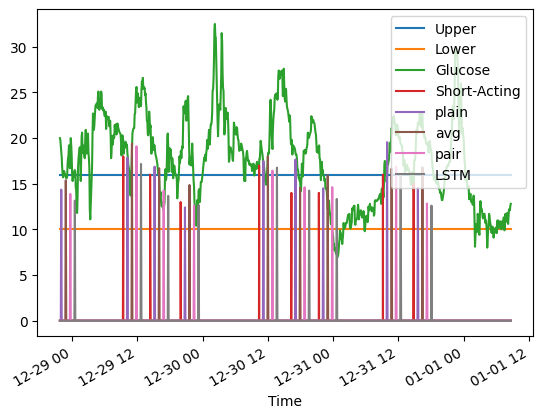

In [90]:
#graphing the real and different types of predicted data

df[4000:5000].plot(x='Time', y=["Upper", "Lower", 'Glucose', "Short-Acting", "plain", "avg", "pair", "LSTM"])